<a href="https://colab.research.google.com/github/JinFree/models/blob/master/object_detection_api_in_colab_with_gdrive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 1.x
!apt-get install -y -qq protobuf-compiler python-pil python-lxml python-tk
!pip install Cython | grep Successfully 
from google.colab import drive
drive.mount('/content/gdrive')

Selecting previously unselected package python-bs4.
(Reading database ... 145653 files and directories currently installed.)
Preparing to unpack .../0-python-bs4_4.6.0-1_all.deb ...
Unpacking python-bs4 (4.6.0-1) ...
Selecting previously unselected package python-pkg-resources.
Preparing to unpack .../1-python-pkg-resources_39.0.1-2_all.deb ...
Unpacking python-pkg-resources (39.0.1-2) ...
Selecting previously unselected package python-chardet.
Preparing to unpack .../2-python-chardet_3.0.4-1_all.deb ...
Unpacking python-chardet (3.0.4-1) ...
Selecting previously unselected package python-six.
Preparing to unpack .../3-python-six_1.11.0-2_all.deb ...
Unpacking python-six (1.11.0-2) ...
Selecting previously unselected package python-webencodings.
Preparing to unpack .../4-python-webencodings_0.5-2_all.deb ...
Unpacking python-webencodings (0.5-2) ...
Selecting previously unselected package python-html5lib.
Preparing to unpack .../5-python-html5lib_0.999999999-1_all.deb ...
Unpacking pyt

In [2]:
%cd /content
!git clone https://github.com/tensorflow/models.git
!git clone https://github.com/cocodataset/cocoapi.git
%cd /content/cocoapi/PythonAPI 
!make 
!cp -r pycocotools /content/models/research/
%cd /content/models/research
%set_env PYTHONPATH=/content/models/research:/content/models/research/slim
!protoc object_detection/protos/*.proto --python_out=.

/content
Cloning into 'models'...
remote: Enumerating objects: 1118, done.
remote: Counting objects: 100% (1118/1118), done.
remote: Compressing objects: 100% (702/702), done.
remote: Total 33176 (delta 643), reused 715 (delta 415), pack-reused 32058
Receiving objects: 100% (33176/33176), 512.35 MiB | 43.65 MiB/s, done.
Resolving deltas: 100% (20953/20953), done.
Checking out files: 100% (3188/3188), done.
Cloning into 'cocoapi'...
remote: Enumerating objects: 959, done.
remote: Total 959 (delta 0), reused 0 (delta 0), pack-reused 959
Receiving objects: 100% (959/959), 11.69 MiB | 37.87 MiB/s, done.
Resolving deltas: 100% (570/570), done.
/content/cocoapi/PythonAPI
python setup.py build_ext --inplace
running build_ext
cythoning pycocotools/_mask.pyx to pycocotools/_mask.c
/usr/local/lib/python3.6/dist-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /content/cocoapi/PythonAP

In [3]:
%set_env PYTHONPATH=/content/models/research:/content/models/research/slim
%cd /content/models/research
!python object_detection/builders/model_builder_test.py

env: PYTHONPATH=/content/models/research:/content/models/research/slim
/content/models/research
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



Running tests under Python 3.6.9: /usr/bin/python3
[ RUN      ] ModelBuilderTest.test_create_experimental_model
[       OK ] ModelBuilderTest.test_create_experimental_model
[ RUN      ] ModelBuilderTest.test_create_faster_rcnn_model_from_config_with_example_miner
[       OK ] ModelBuilderTest.test_create_faster_rcnn_model_from_config_with_example_miner
[ RUN      ] ModelBuilderTest.test_create_faster_rcnn_models_from_config_faster_rcnn_with_matmul
[       OK ] ModelBuilderTest.test_create_faster_rcnn_models_from_config_faster_rcnn_w

/content/models/research/object_detection


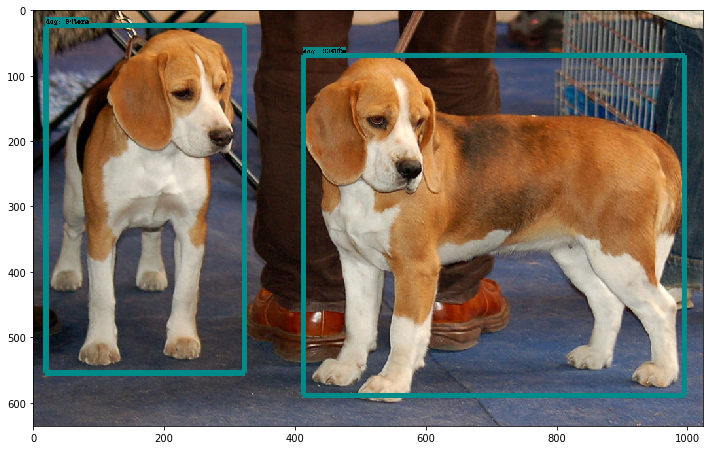

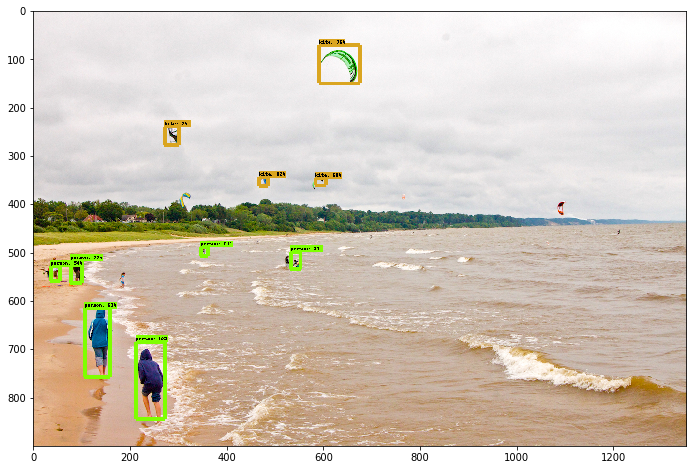

In [5]:
%tensorflow_version 1.x
%cd /content/models/research/object_detection
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from distutils.version import StrictVersion
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops

if StrictVersion(tf.__version__) < StrictVersion('1.12.0'):
  raise ImportError('Please upgrade your TensorFlow installation to v1.12.*.')
# This is needed to display the images.
%matplotlib inline
from utils import label_map_util

from utils import visualization_utils as vis_util
# What model to download.
MODEL_NAME = 'ssd_mobilenet_v1_coco_2017_11_17'
MODEL_FILE = MODEL_NAME + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_FROZEN_GRAPH = MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('data', 'mscoco_label_map.pbtxt')
opener = urllib.request.URLopener()
opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
tar_file = tarfile.open(MODEL_FILE)
for file in tar_file.getmembers():
  file_name = os.path.basename(file.name)
  if 'frozen_inference_graph.pb' in file_name:
    tar_file.extract(file, os.getcwd())
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)
# For the sake of simplicity we will use only 2 images:
# image1.jpg
# image2.jpg
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = 'test_images'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(1, 3) ]

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[1], image.shape[2])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: image})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.int64)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict
for image_path in TEST_IMAGE_PATHS:
  image = Image.open(image_path)
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
  output_dict = run_inference_for_single_image(image_np_expanded, detection_graph)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=8)
  plt.figure(figsize=IMAGE_SIZE)
  plt.imshow(image_np)


In [0]:
%cd /content
!mkdir coco
%cd /content/coco
!wget -q http://images.cocodataset.org/zips/train2014.zip
!wget -q http://images.cocodataset.org/zips/val2014.zip
!wget -q http://images.cocodataset.org/zips/test2014.zip
!wget -q http://images.cocodataset.org/annotations/annotations_trainval2014.zip
!wget -q http://images.cocodataset.org/annotations/image_info_test2014.zip
!unzip -qq train2014.zip 
!ls
!unzip -qq val2014.zip 
!ls
!unzip -qq test2014.zip 
!ls
!unzip -qq annotations_trainval2014.zip 
!ls
!unzip -qq image_info_test2014.zip

/content
/content/coco


In [0]:
!ls /content/coco/annotations

In [0]:
%cd /content/coco
!rm -rf tfrecord
!mkdir tfrecord
%set_env PYTHONPATH=/content/models/research:/content/models/research/slim
%cd /content/models/research/object_detection/dataset_tools
!python create_coco_tf_record.py --logtostderr \
      --train_image_dir=/content/coco/train2014/ \
      --val_image_dir=/content/coco/val2014/ \
      --test_image_dir=/content/coco/test2014/ \
      --train_annotations_file=/content/coco/annotations/instances_train2014.json \
      --val_annotations_file=/content/coco/annotations/instances_val2014.json \
      --testdev_annotations_file=/content/coco/annotations/image_info_test2014.json \
      --output_dir=/content/coco/tfrecord | grep Finished

In [0]:
!pwd
%cd /content/coco/tfrecord
!ls

In [0]:
%cd /content/coco
!wget http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v2_coco_2018_03_29.tar.gz
!tar -xzvf ssd_mobilenet_v2_coco_2018_03_29.tar.gz
!ls /content/coco/ssd_mobilenet_v2_coco_2018_03_29/

In [0]:
%cd /content/coco
!mkdir config_dir
%cd /content/coco/config_dir
!wget https://raw.githubusercontent.com/JinFree/models/master/ssd_inceptionv2_in_colab.config
!ls /content/coco/config_dir

In [0]:
%cd /content/models/research
!python object_detection/model_main.py \
    --pipeline_config_path=/content/coco/config_dir/ssd_inceptionv2_in_colab.config \
    --model_dir=/content/coco/config_dir/ \
    --num_train_steps=50000 \
    --sample_1_of_n_eval_examples=1 \
    --alsologtostderr

In [0]:
!ls /content/coco/config_dir/

In [0]:
%cd /content/coco/
!rm -rf ssd_mobilenet_v2_coco_2018_03_29
!mkdir ssd_mobilenet_v2_coco_2018_03_29
%cd /content/models/research
!python object_detection/export_inference_graph.py \
    --input_type=image_tensor \
    --pipeline_config_path=/content/coco/config_dir/ssd_inceptionv2_in_colab.config \
    --trained_checkpoint_prefix=/content/coco/config_dir/model.ckpt-485 \
    --output_directory=/content/coco/ssd_mobilenet_v2_coco_2018_03_29/
!ls /content/coco/ssd_mobilenet_v2_coco_2018_03_29/

In [0]:
!rm -rf /content/coco/config_dir
!mkdir /content/coco/config_dir
%cd /content/coco/config_dir
!wget https://raw.githubusercontent.com/JinFree/models/master/ssd_inceptionv2_in_colab.config

In [0]:
%cd  /content/gdrive/'My Drive'/
!rm -rf tf_trained
!mkdir tf_trained
!cp -r /content/coco/ssd_mobilenet_v2_coco_2018_03_29 /content/gdrive/'My Drive'/tf_trained
!ls /content/gdrive/'My Drive'/tf_trained/ssd_mobilenet_v2_coco_2018_03_29